In [2]:
#Setup
import warnings
import skillsnetwork

warnings.filterwarnings("ignore")
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, precision_recall_curve, roc_auc_score, roc_curve, accuracy_score
from sklearn.ensemble import RandomForestClassifier

In [3]:
## Import Keras objects for Deep Learning
from tensorflow.keras.models  import Sequential
from tensorflow.keras.layers import Input, Dense, Flatten, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam, SGD, RMSprop


In [4]:
## Load in the data set 
names = ["times_pregnant", "glucose_tolerance_test", "blood_pressure", "skin_thickness", "insulin", 
         "bmi", "pedigree_function", "age", "has_diabetes"]
diabetes_df = pd.read_csv('./diabetes.csv', names=names, header=0)

In [5]:
# Take a peek at the data -- if there are lots of "NaN" you may have internet connectivity issues
print(diabetes_df.shape)
diabetes_df.sample(5)

(768, 9)


,times_pregnant,glucose_tolerance_test,blood_pressure,skin_thickness,insulin,bmi,pedigree_function,age,has_diabetes
278,5,114,74,0,0,24.9,0.744,57,0
302,5,77,82,41,42,35.8,0.156,35,0
653,2,120,54,0,0,26.8,0.455,27,0
417,4,144,82,32,0,38.5,0.554,37,1
297,0,126,84,29,215,30.7,0.520,24,0


In [6]:
X = diabetes_df.iloc[:, :-1].values
y = diabetes_df["has_diabetes"].values

In [7]:
# Split the data to Train, and Test (75%, 25%)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=11111)

In [8]:
np.mean(y), np.mean(1-y)
# Above, we see that about 35% of the patients in this dataset have diabetes, while 65% do not. 
# This means we can get an accuracy of 65% without any model - just declare that no one has diabetes. 
# We will calculate the ROC-AUC score to evaluate performance of our model, and also look at the accuracy as well to see if we improved upon the 65% accuracy.

(0.3489583333333333, 0.6510416666666666)

In [9]:
### BEGIN SOLUTION
## Train the RF Model
rf_model = RandomForestClassifier(n_estimators=200)
rf_model.fit(X_train, y_train)

RandomForestClassifier(n_estimators=200)

In [10]:
# Make predictions on the test set - both "hard" predictions, and the scores (percent of trees voting yes)
y_pred_class_rf = rf_model.predict(X_test)
y_pred_prob_rf = rf_model.predict_proba(X_test)


print('accuracy is {:.3f}'.format(accuracy_score(y_test,y_pred_class_rf)))
print('roc-auc is {:.3f}'.format(roc_auc_score(y_test,y_pred_prob_rf[:,1])))

accuracy is 0.781
roc-auc is 0.820


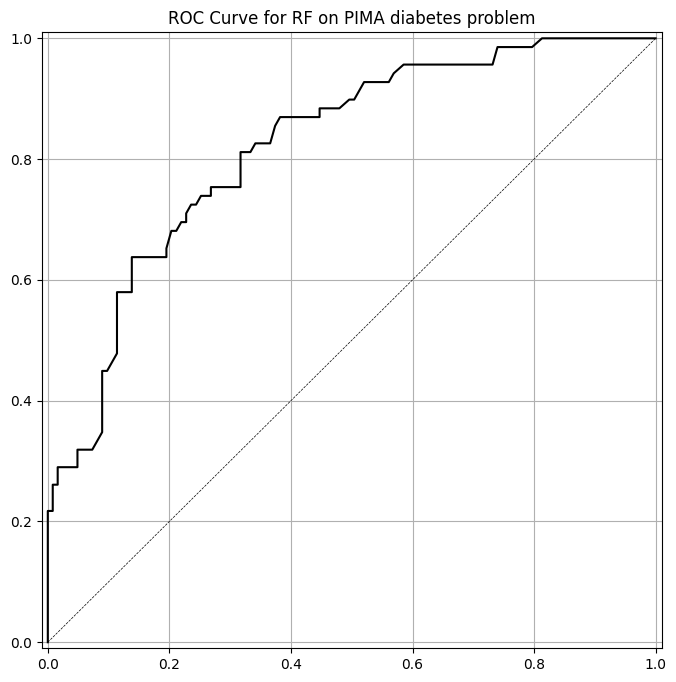

In [11]:
def plot_roc(y_test, y_pred, model_name):
    fpr, tpr, thr = roc_curve(y_test, y_pred)
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.plot(fpr, tpr, 'k-')
    ax.plot([0, 1], [0, 1], 'k--', linewidth=.5)  # roc curve for random model
    ax.grid(True)
    ax.set(title='ROC Curve for {} on PIMA diabetes problem'.format(model_name),
           xlim=[-0.01, 1.01], ylim=[-0.01, 1.01])
plot_roc(y_test, y_pred_prob_rf[:, 1], 'RF')
### END SOLUTION

In [12]:
## First let's normalize the data
## This aids the training of neural nets by providing numerical stability
## Random Forest does not need this as it finds a split only, as opposed to performing matrix multiplications

normalizer = StandardScaler()
X_train_norm = normalizer.fit_transform(X_train)
X_test_norm = normalizer.transform(X_test)

In [13]:
# Define the Model 
# Input size is 8-dimensional
# 1 hidden layer, 12 hidden nodes, sigmoid activation
# Final layer has just one node with a sigmoid activation (standard for binary classification)

model_1 = Sequential()
model_1.add(Dense(12,input_shape = (8,),activation = 'sigmoid'))
model_1.add(Dense(1,activation='sigmoid'))

In [14]:
#  This is a nice tool to view the model you have created and count the parameters

model_1.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 12)             │           108 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            13 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 121 (484.00 B)

 Trainable params: 121 (484.00 B)

 Non-trainable params: 0 (0.00 B)

In [15]:
# Fit(Train) the Model

# Compile the model with Optimizer, Loss Function and Metrics
# Roc-Auc is not available in Keras as an off the shelf metric yet, so we will skip it here.

model_1.compile(optimizer=SGD(learning_rate=0.003), loss="binary_crossentropy", metrics=["accuracy"])
run_hist_1 = model_1.fit(X_train_norm, y_train, validation_data=(X_test_norm, y_test), epochs=200)
# the fit function returns the run history. 
# It is very convenient, as it contains information about the model fit, iterations etc.

Epoch 1/200
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.6080 - loss: 0.6817 - val_accuracy: 0.5573 - val_loss: 0.6989
Epoch 2/200
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6106 - loss: 0.6791 - val_accuracy: 0.5573 - val_loss: 0.6963
Epoch 3/200
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5912 - loss: 0.6840 - val_accuracy: 0.5677 - val_loss: 0.6939
Epoch 4/200
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6056 - loss: 0.6833 - val_accuracy: 0.5677 - val_loss: 0.6916
Epoch 5/200
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6398 - loss: 0.6740 - val_accuracy: 0.5781 - val_loss: 0.6895
Epoch 6/200
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6115 - loss: 0.6788 - val_accuracy: 0.5938 - val_loss: 0.6875
Epoch 7/200
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.6200 - loss: 0.6742 - val_accuracy: 0.5990 - val_loss: 0.6857
Epoch 8/200
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6164 - loss: 0.6746 - val_accuracy: 0.5938 - 

In [16]:
## Like we did for the Random Forest, we generate two kinds of predictions
#  One is a hard decision, the other is a probabilitistic score.

y_pred_prob_nn_1 = model_1.predict(X_test_norm)
y_pred_class_nn_1 = (y_pred_prob_nn_1 > 0.5).astype(int)

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


In [17]:
# Let's check out the outputs to get a feel for how keras apis work.
y_pred_class_nn_1[:10]

array([[0],
       [1],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [1],
       [0]])

In [18]:
y_pred_prob_nn_1[:10]

array([[0.35119295],
       [0.5269785 ],
       [0.39574152],
       [0.35328782],
       [0.29948154],
       [0.4191123 ],
       [0.19078118],
       [0.3414123 ],
       [0.5370891 ],
       [0.27316812]], dtype=float32)

accuracy is 0.714
roc-auc is 0.790


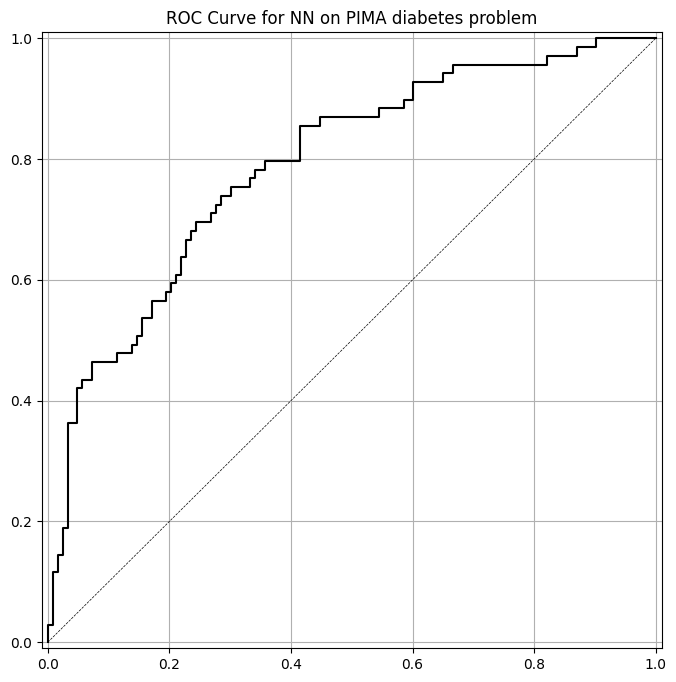

In [19]:
# Print model performance and plot the roc curve
print('accuracy is {:.3f}'.format(accuracy_score(y_test,y_pred_class_nn_1)))
print('roc-auc is {:.3f}'.format(roc_auc_score(y_test,y_pred_prob_nn_1)))

plot_roc(y_test, y_pred_prob_nn_1, 'NN')

In [20]:
run_hist_1.history.keys()

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])

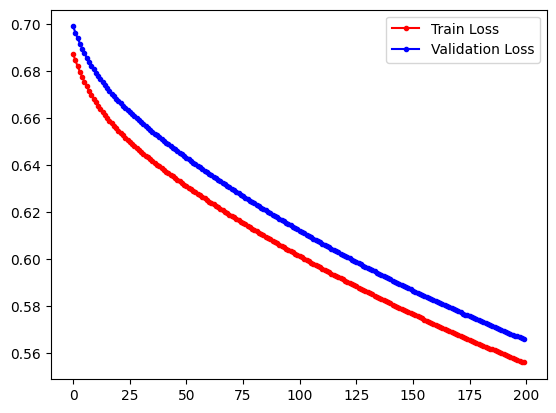

In [21]:
fig, ax = plt.subplots()
ax.plot(run_hist_1.history["loss"],'r', marker='.', label="Train Loss")
ax.plot(run_hist_1.history["val_loss"],'b', marker='.', label="Validation Loss")
ax.legend()

In [22]:
## Note that when we call "fit" again, it picks up where it left off
run_hist_1b = model_1.fit(X_train_norm, y_train, validation_data=(X_test_norm, y_test), epochs=1000)

Epoch 1/1000
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6812 - loss: 0.5623 - val_accuracy: 0.7188 - val_loss: 0.5655
Epoch 2/1000
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7065 - loss: 0.5357 - val_accuracy: 0.7188 - val_loss: 0.5652
Epoch 3/1000
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7042 - loss: 0.5412 - val_accuracy: 0.7188 - val_loss: 0.5648
Epoch 4/1000
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7263 - loss: 0.5417 - val_accuracy: 0.7188 - val_loss: 0.5644
Epoch 5/1000
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7149 - loss: 0.5414 - val_accuracy: 0.7188 - val_loss: 0.5640
Epoch 6/1000
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6965 - loss: 0.5534 - val_accuracy: 0.7188 - val_loss: 0.5637
Epoch 7/1000
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6931 - loss: 0.5689 - val_accuracy: 0.7188 - val_loss: 0.5633
Epoch 8/1000
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7065 - loss: 0.5554 - val_accuracy: 0.

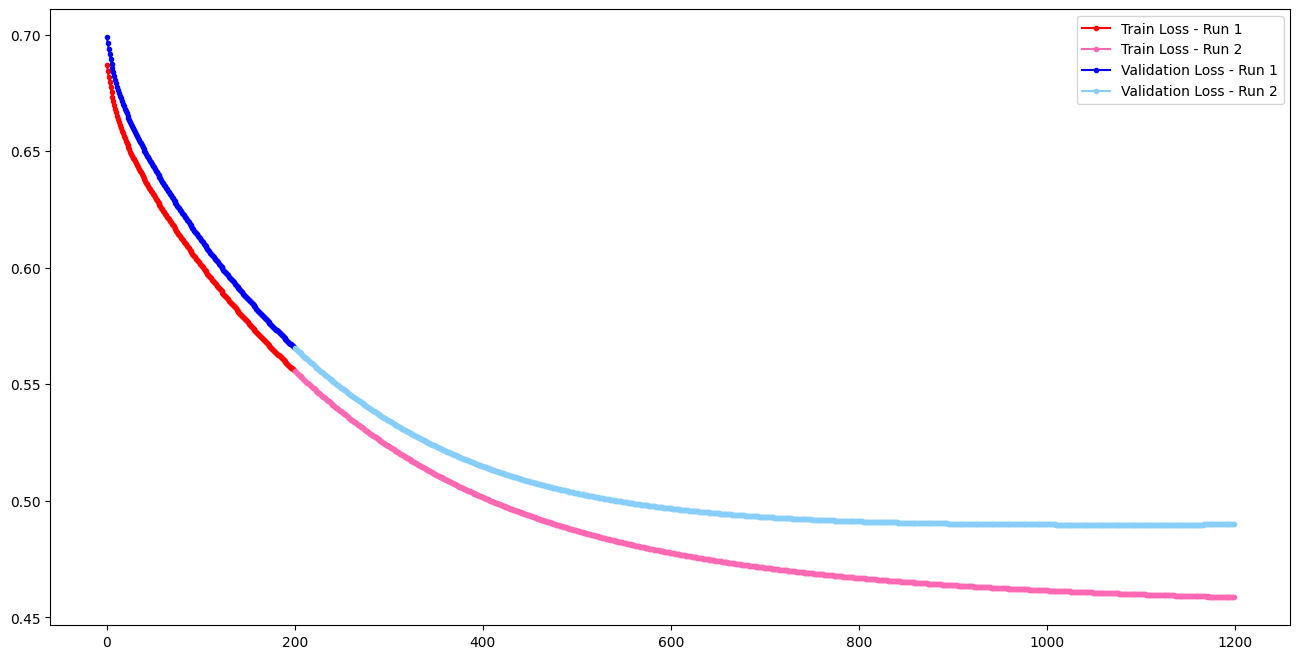

In [23]:
n = len(run_hist_1.history["loss"])
m = len(run_hist_1b.history['loss'])
fig, ax = plt.subplots(figsize=(16, 8))

ax.plot(range(n), run_hist_1.history["loss"],'r', marker='.', label="Train Loss - Run 1")
ax.plot(range(n, n+m), run_hist_1b.history["loss"], 'hotpink', marker='.', label="Train Loss - Run 2")

ax.plot(range(n), run_hist_1.history["val_loss"],'b', marker='.', label="Validation Loss - Run 1")
ax.plot(range(n, n+m), run_hist_1b.history["val_loss"], 'LightSkyBlue', marker='.',  label="Validation Loss - Run 2")

ax.legend()

In [25]:
### BEGIN SOLUTION
model_2 = Sequential()
model_2.add(Dense(6, input_shape=(8,), activation="relu"))
model_2.add(Dense(6,  activation="relu"))
model_2.add(Dense(1, activation="sigmoid"))

model_2.compile(optimizer=SGD(learning_rate=0.003), loss="binary_crossentropy", metrics=["accuracy"])
run_hist_2 = model_2.fit(X_train_norm, y_train, validation_data=(X_test_norm, y_test), epochs=1500)

Epoch 1/1500
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.3411 - loss: 0.8651 - val_accuracy: 0.3698 - val_loss: 0.8045
Epoch 2/1500
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.3223 - loss: 0.8597 - val_accuracy: 0.3854 - val_loss: 0.7890
Epoch 3/1500
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.3525 - loss: 0.8297 - val_accuracy: 0.3802 - val_loss: 0.7753
Epoch 4/1500
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.3936 - loss: 0.7978 - val_accuracy: 0.3906 - val_loss: 0.7633
Epoch 5/1500
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.3672 - loss: 0.8182 - val_accuracy: 0.3906 - val_loss: 0.7525
Epoch 6/1500
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.3795 - loss: 0.7727 - val_accuracy: 0.4219 - val_loss: 0.7429
Epoch 7/1500
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.3648 - loss: 0.7906 - val_accuracy: 0.4427 - val_loss: 0.7343
Epoch 8/1500
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.3863 - loss: 0.7397 - val_accuracy: 0.

KeyError: 'acc'

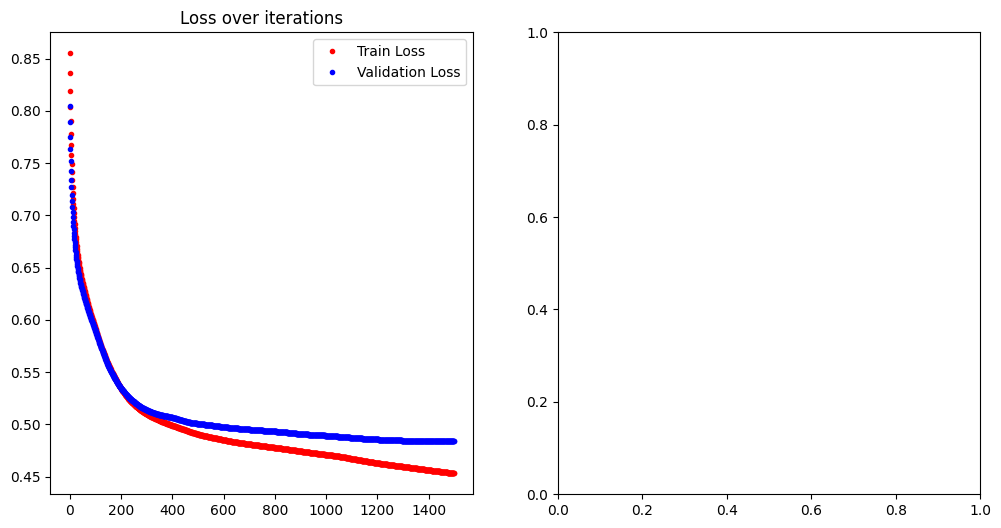

In [27]:
n = len(run_hist_2.history["loss"])

fig = plt.figure(figsize=(12, 6))
ax = fig.add_subplot(1, 2, 1)
ax.plot(range(n), (run_hist_2.history["loss"]),'r.', label="Train Loss")
ax.plot(range(n), (run_hist_2.history["val_loss"]),'b.', label="Validation Loss")
ax.legend()
ax.set_title('Loss over iterations')

ax = fig.add_subplot(1, 2, 2)
ax.plot(range(n), (run_hist_2.history["acc"]),'r.', label="Train Acc")
ax.plot(range(n), (run_hist_2.history["val_acc"]),'b.', label="Validation Acc")
ax.legend(loc='lower right')
ax.set_title('Accuracy over iterations')

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 988us/step

accuracy is 0.641
roc-auc is 0.825


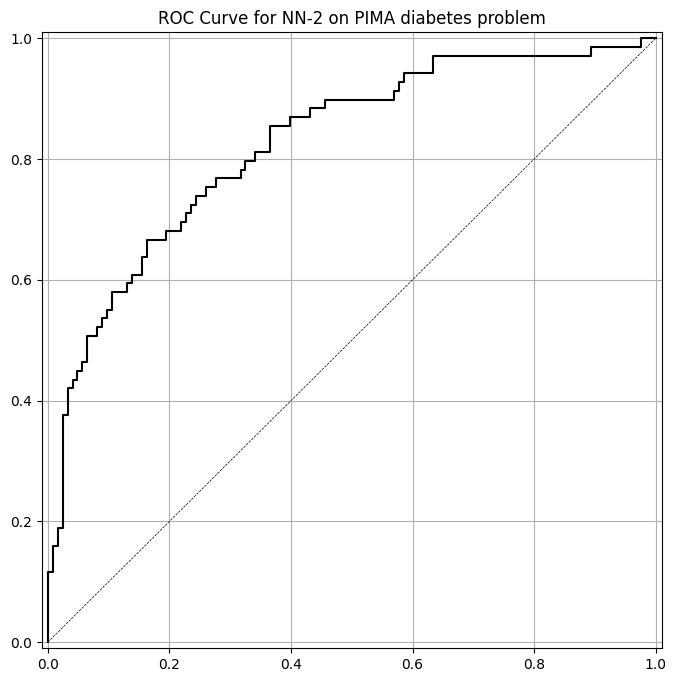

In [31]:

predict_x=model_2.predict(X_test_norm) 
classes_x=np.argmax(predict_x,axis=1)
y_pred_prob_nn_2 = model_2.predict(X_test_norm)
print('')
print('accuracy is {:.3f}'.format(accuracy_score(y_test,classes_x)))
print('roc-auc is {:.3f}'.format(roc_auc_score(y_test,y_pred_prob_nn_2)))

plot_roc(y_test, y_pred_prob_nn_2, 'NN-2')
### END SOLUTION